# The Problem of Cyber Bullying
> With the rise of social media and degraded morality, cyber bullying has become a terrible menace of modern times. Social Media grants us anonymity, 
which leads some distorted minds to think they can get away with anything. So they pick out on people, befriend them and then shower them with hate.
    
> The problem may seem to some to be another sort of high school bully. But cyber bullying is done on social media where information is permanant. 
So this becomes a lifelong trauma for victims. Depression and Suicide are common after effects of this nemesis, but not much has been done to curb this menace.

# Importing the Data

In [1]:
# Imports for common tasks, models imported later
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import re
import gensim
import missingno as msn
from IPython.display import Image
%matplotlib inline

In [2]:
# First checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#df = pd.read_csv("/kaggle/input/formspring-csv/formspring.csv", nrows=1000)
df = pd.read_csv("/kaggle/input/formspring-csv/formspring.csv")
# See first few rows
df.head()

,userid,post,ques,ans,asker,ans1,severity1,bully1,ans2,severity2,bully2,ans3,severity3,bully3
0,aguitarplayer94,Q: what&#039;s your favorite song? :D<br>A: I ...,what&#039;s your favorite song? :D<br>,I like too many songs to have a favorite,None,No,0,NaN,No,0,NaN,No,0,NaN
1,aprilpooh15,Q: <3<br>A: </3 ? haha jk! <33,<3,</3 ? haha jk! <33,None,No,0,NaN,No,0,NaN,No,0,NaN
2,aprilpooh15,Q: &quot;hey angel you duh sexy&quot;<br>A: R...,&quot;hey angel you duh sexy&quot;,Really?!?! Thanks?! haha,None,No,0,NaN,No,0,NaN,No,0,NaN
3,aprilpooh15,Q: (:<br>A: ;(,(:,;(,None,No,0,NaN,No,0,NaN,No,0,NaN
4,aprilpooh15,Q: ******************MEOWWW*******************...,******************MEOWWW*************************,*RAWR*?,None,No,0,NaN,No,0,NaN,No,0,NaN


# Exploration of the dataset

## 1. BarPlot of missing values

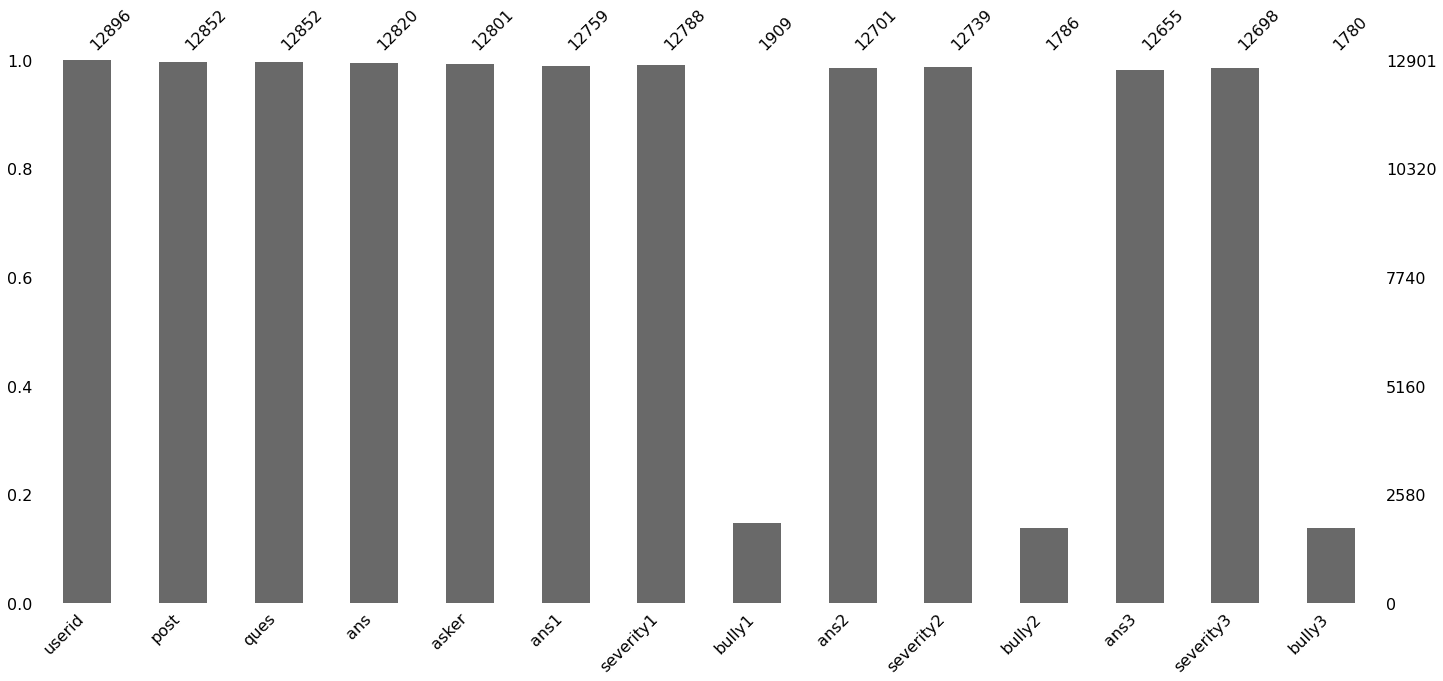

In [4]:
# missing values visualisation
msn.bar(df);

# Insights about the data set
* userid - userid of a person giving the answer to a post
* post - The post and it's reply. Separated by Q: and A.
* ques and ans - The question and answer. The same information is available in post, so we drop post
* asker - id of the person asking the question.
* ans #, severity #, bully # - answer by mechanical turk, severity score assigned, bully word/phrase

In [5]:
df.drop(['post', 'asker', 'bully1', 'bully2', 'bully3'], axis = 1, inplace = True)

In [6]:
df.head()

,userid,ques,ans,ans1,severity1,ans2,severity2,ans3,severity3
0,aguitarplayer94,what&#039;s your favorite song? :D<br>,I like too many songs to have a favorite,No,0,No,0,No,0
1,aprilpooh15,<3,</3 ? haha jk! <33,No,0,No,0,No,0
2,aprilpooh15,&quot;hey angel you duh sexy&quot;,Really?!?! Thanks?! haha,No,0,No,0,No,0
3,aprilpooh15,(:,;(,No,0,No,0,No,0
4,aprilpooh15,******************MEOWWW*************************,*RAWR*?,No,0,No,0,No,0


In [7]:
#unique_values = df['severity1'].unique()

#print(unique_values) 

# Imputing Missing Values and Replacing values

## 1. ans columns
NaN for ans columns indicates No Bully found. We will map every Yes to 1 and every No or NaN to 0

In [8]:
def impute_ans_columns(value):
    v = ['No','nan']
    if value in v:
        return 0
    return 1

In [9]:
for col in ['ans1', 'ans2', 'ans3']:
    df[col] = df[col].apply(impute_ans_columns)
df.sample(10)

,userid,ques,ans,ans1,severity1,ans2,severity2,ans3,severity3
9917,kellyblake1,Who are you rooting for in the Winter Olympics?,Ummm the UK? I dont even know who is in it :...,0,0,0,0,0,0
9520,kellyblake1,oh god how many questions did i ask you??? ha...,Hmm about 80 missy :P If this site was actua...,0,0,0,0,0,0
1405,teaachgee,Have you ever used drugs?,yep,0,0,0,0,0,0
9531,kellyblake1,OMG WHO KNEW THAT WAS SAY ANYTHING!! I LOVE TH...,Good good. Glad you have found love. It's rar...,0,0,0,0,0,0
12870,outlaw9000,you might think im evil but.. me and my mate w...,LMAO fucker face,1,3,0,0,1,3
8275,"""""""""hop off my dick""""""""""""""",7,Q: I don't wanna fucking get anything in with ...,1,NaN,1,NaN,1,NaN
11576,outlaw9000,Have you ever smelled someone&#039;s gauges?,what are Gauges ??,0,0,0,0,0,0
5845,zooshay,How many nieces and nephews do you have :) ?? ...,hmm one sister has 5 kids all boysr another h...,0,0,0,0,0,0
5966,zooshay,i drink it straight,yummm i dont i mix it with lemonade,0,0,0,0,0,1
55,aprilpooh15,hehe yup it&#039;s awesome but the pronuncia...,haha!! it is haha lol!! man i hvnt even gotte...,0,0,0,0,0,0


## 2. severity columns
* NaN/None was associated with a No(0) that is 0 severity mostly.

So we will replace all NaN/None with 0.

In [10]:
def impute_severity_columns(value):
    '''Value will be a string. We need to convert it to int'''
    v = ['nan', 'None', '0']
    if value in v:
        return 0
    try:
        return int(value)
    except ValueError as e:
        #print(value)
        return 5

In [11]:
for col in ['severity1', 'severity2', 'severity3']:
    df[col] = df[col].apply(impute_severity_columns)

In [12]:
df.sample(10)

,userid,ques,ans,ans1,severity1,ans2,severity2,ans3,severity3
452,moonbeemashlee,who are you?,yo momma,1,5,1,1,0,0
7649,avlarios,Coldstone,K can I carry you on my shoulders like a lit...,0,0,0,0,0,0
877,teaachgee,did you remember to get those rings and earrin...,Yes ma'am :] thank you lady.,0,0,0,0,0,0
6946,zooshay,What is the first physical thing you notice in...,eyes lips,0,0,0,0,0,0
12121,outlaw9000,my tummy is telling me its hungry.... what sho...,roasted garlic chicken yummy,1,6,0,0,0,0
5283,zooshay,Chocolate or Vanilla?,Chocolate,0,0,0,0,0,0
11173,outlaw9000,do you drink? would you date someone who drinked?,yes and yes,0,0,0,0,0,0
7849,avlarios,I&#039;ve been asked that question like 13 times,shuddup fool,1,2,0,0,1,3
9389,kellyblake1,is it wrong to like boys ?,no lol. Thats like saying is it wrong to like...,0,0,0,0,0,0
10558,maurice28,http://www.larissaweber.de.vu/?id=9322e7,that's broken :P,0,0,0,0,0,0


# Creating the target feature
Since in this dataset, we have not been given any target feature, we will create our own target feature.

```python
isBully = ((ans1 * severity1) + (ans2 * severity2) + (ans3 * severity3)) / 30 >= 0.20
```

We are taking 0.2 as our threshold

In [13]:
df['IsBully'] = (
    (df.ans1 * df.severity1 + df.ans2 * df.severity2 + df.ans3 * df.severity3) / 30) >= 0.0333

# Remove uneccessary columns
df_2 = df.drop(['userid','ans1', 'severity1','ans2','severity2','ans3','severity3'], axis = 1)

In [14]:
df_2.sample(10)

,ques,ans,IsBully
11442,fave word or saying ?,fuck,False
628,r u &amp; Frances still talken?,Yeah. why?,False
5406,do you believe we evolved from apes?,nope not at all,False
7916,NaN,NaN,True
10301,Yeh you she was like drama not healthy and the...,i sed EXSACTLY and i noe dis amber im not dum...,True
2892,kan u wam? Because i love lil wayne and da wam...,lol gurl iKan do anythang,False
3196,damn. Flirting with another girls boyfriend. I...,ummmmmmmmmmmmmm. i didnt no and we were joki...,True
5136,&amp; is your heart better then the rest?,yes it is,False
11608,Hello everyone. :D I&#039;m going to have a ve...,Very good thanxxx,False
3864,If rabbitsu2019 feet are so lucky then what h...,good question:],False


In [15]:
false_count = (df_2['IsBully'] == False).sum()
print(f"Number of rows where isBully is False: {false_count}")

Number of rows where isBully is False: 10925


In [16]:
true_count = (df_2['IsBully'] == True).sum()
print(f"Number of rows where isBully is True: {true_count}")

Number of rows where isBully is True: 1976


# Text Cleaning

In [17]:
for col in ['ques', 'ans']:
    df_2[col] = df_2[col].str.replace("&#039;", "'") # Put back the apostrophe

    df_2[col] = df_2[col].str.replace("<br>", "") 
    df_2[col] = df_2[col].str.replace("&quot;", "") 
    #df_2[col] = df_2[col].str.replace("<3", "love")
    
df_2.head()

,ques,ans,IsBully
0,what's your favorite song? :D,I like too many songs to have a favorite,False
1,<3,</3 ? haha jk! <33,False
2,hey angel you duh sexy,Really?!?! Thanks?! haha,False
3,(:,;(,False
4,******************MEOWWW*************************,*RAWR*?,False


In [18]:
df_2['ques_ans'] = df_2['ques'] + ' ' + df_2['ans'] 

In [19]:
df_2.head()

,ques,ans,IsBully,ques_ans
0,what's your favorite song? :D,I like too many songs to have a favorite,False,what's your favorite song? :D I like too many...
1,<3,</3 ? haha jk! <33,False,<3 </3 ? haha jk! <33
2,hey angel you duh sexy,Really?!?! Thanks?! haha,False,hey angel you duh sexy Really?!?! Thanks?! haha
3,(:,;(,False,(: ;(
4,******************MEOWWW*************************,*RAWR*?,False,******************MEOWWW**********************...


In [20]:
import string
df_2.drop(['ques','ans'], axis=1)
columns = ['ques_ans','IsBully']
df2_ordered = df_2[columns]
df2_ordered['ques_ans'] = df2_ordered['ques_ans'].str.lower()
# Remove punctuation using regex
df2_ordered['ques_ans'] = df2_ordered['ques_ans'].str.replace(f'[{string.punctuation}]', '', regex=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [21]:
df2_ordered = df2_ordered[df2_ordered['ques_ans'].notna()]  # Remove NaN values
df2_ordered = df2_ordered[df2_ordered['ques_ans'].str.strip() != '']  # Remove empty strings
df2_ordered.head()

,ques_ans,IsBully
0,whats your favorite song d i like too many so...,False
1,3 3 haha jk 33,False
2,hey angel you duh sexy really thanks haha,False
4,meowww rawr,False
5,any makeup tips i suck at doing my makeup lol ...,False


In [22]:
from imblearn.under_sampling import RandomUnderSampler

# Assuming X_train is your feature matrix and y_train is your target (label)
undersampler = RandomUnderSampler(random_state=42)

# Perform undersampling
X_resampled, y_resampled = undersampler.fit_resample(df2_ordered['ques_ans'].values.reshape(-1, 1), df2_ordered['IsBully'])
# Check the new class distribution after undersampling
#print("Original class distribution:", df2_ordered['ques_ans'].value_counts())
print("Resampled class distribution:", pd.Series(y_resampled).value_counts())

Resampled class distribution: True     1897
False    1897
Name: IsBully, dtype: int64


In [23]:
X = df2_ordered['ques_ans'].values
y = df2_ordered['IsBully'].values

In [24]:
!/opt/conda/bin/python3.7 -m pip install --upgrade pip

In [25]:
!pip install tornado==5.1
!pip install --upgrade openai

  Using cached openai-1.53.0-py3-none-any.whl.metadata (24 kB)
INFO: pip is looking at multiple versions of openai to determine which version is compatible with other requirements. This could take a while.
  Using cached openai-1.52.2-py3-none-any.whl.metadata (24 kB)
  Using cached openai-1.52.1-py3-none-any.whl.metadata (24 kB)
  Using cached openai-1.52.0-py3-none-any.whl.metadata (24 kB)
  Using cached openai-1.51.2-py3-none-any.whl.metadata (24 kB)
  Using cached openai-1.51.1-py3-none-any.whl.metadata (24 kB)
  Using cached openai-1.51.0-py3-none-any.whl.metadata (24 kB)
  Using cached openai-1.50.2-py3-none-any.whl.metadata (24 kB)
INFO: pip is still looking at multiple versions of openai to determine which version is compatible with other requirements. This could take a while.
  Using cached openai-1.50.1-py3-none-any.whl.metadata (24 kB)
  Using cached openai-1.50.0-py3-none-any.whl.metadata (24 kB)
  Using cached openai-1.49.0-py3-none-any.whl.metadata (24 kB)
  Using cached 

In [26]:
#!pip install --upgrade typing_extensions
!pip install --upgrade typing_extensions

In [27]:
import openai

In [28]:
embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"
max_tokens = 8000  # the maximum for text-embedding-3-small is 8191

In [29]:
import openai
from openai import OpenAI
api_key = "OPENAI_API_KEY"
client = OpenAI(api_key="OPENAI_API_KEY")


def get_embedding(text: str, model="text-embedding-3-large", **kwargs):
    # replace newlines, which can negatively affect performance.
    text = text.replace("\n", " ")

    response = client.embeddings.create(input=[text], model=model, **kwargs)

    return response.data[0].embedding

In [30]:
# Reshape X_resampled and y_resampled if necessary
X_resampled_np = X_resampled.reshape(-1) if X_resampled.ndim > 1 else X_resampled
y_resampled_np = y_resampled.reshape(-1) if y_resampled.ndim > 1 else y_resampled

# Now create the DataFrame
df_resampled = pd.DataFrame({
    "ques_ans": X_resampled_np,
    "IsBully": y_resampled_np
})

df_resampled["embedding"] = df_resampled["ques_ans"].apply(lambda x: get_embedding(x))


In [31]:
df_resampled.head()

,ques_ans,IsBully,embedding
0,how many kids do you want 3 or 4,False,"[-0.0190693698823452, -0.010231859050691128, -..."
1,if i love you would that make you happy love ...,False,"[-0.04160841554403305, -0.008513014763593674, ..."
2,i take it you use to kick it at weymouth lol ...,False,"[-0.0011672661639750004, 0.03217288851737976, ..."
3,has mistaflintstone decided to let me have you...,False,"[0.01943144015967846, 0.05315365269780159, -0...."
4,im sorry to hear about your dog thankks,False,"[-0.01834849640727043, 0.022373240441083908, -..."


In [32]:
## Convert embeddings to a list of lists, ensuring they are flattened
embeddings_list = [embedding if isinstance(embedding[0], (float, int)) else embedding[0] for embedding in df_resampled["embedding"].to_list()]

# Convert to a PyTorch tensor
embeddings_tensor = torch.tensor(embeddings_list, dtype=torch.float32).squeeze()

# Check the shape
print(embeddings_tensor.shape)  # Should output (3802, 1536)

torch.Size([3794, 3072])


In [33]:
print(embeddings_tensor.shape) 

torch.Size([3794, 3072])


In [34]:
batch_size = 32
embedding_dim = embeddings_tensor.shape[1]

# Train Test Split

In [36]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    embeddings_tensor.numpy(),  # Convert to NumPy array for splitting
    y_resampled,               # Labels
    test_size=0.2, 
    shuffle=True,
    random_state=42            
)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15,random_state=42, shuffle=True)

# Convert the split data back to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).squeeze()  # Shape: (num_train_samples, 1, embedding_dim)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).squeeze()    # Shape: (num_test_samples, 1, embedding_dim)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).squeeze()   # Shape: (num_test_samples, 1, embedding_dim)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)  # Shape: (num_train_samples, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)    # Shape: (num_test_samples, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)    # Shape: (num_test_samples, 1)

# Check shapes to ensure correctness
print("Training set shapes:", X_train_tensor.shape, y_train_tensor.shape)
print("Testing set shapes:", X_test_tensor.shape, y_test_tensor.shape)
print("Validation set shapes:", X_val_tensor.shape, y_val_tensor.shape)

Training set shapes: torch.Size([2579, 3072]) torch.Size([2579, 1])
Testing set shapes: torch.Size([759, 3072]) torch.Size([759, 1])
Validation set shapes: torch.Size([456, 3072]) torch.Size([456, 1])


# Modelling

In [38]:
from sklearn.metrics import plot_roc_curve
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

# Define the estimators with class weights for imbalance handling
scale_pos_weight = len(y_resampled[y_resampled == 0]) / len(y_resampled[y_resampled == 1]) * 1.5
estimators = [
    ('randomForest_model', RandomForestClassifier(class_weight='balanced')),  # Handle imbalance with class_weight for RandomForest
    ('SGD', SGDClassifier(class_weight='balanced')),  # Handle imbalance with class_weight for SGD
    ('naive_bayes', GaussianNB()),
    ('xgboost', XGBClassifier(scale_pos_weight=scale_pos_weight))
    
]
  # Try adjusting this value
finalEstimator = LogisticRegression(class_weight='balanced')

In [39]:
model = StackingClassifier(estimators=estimators,
                           final_estimator = finalEstimator,
                           cv = 5,
                           n_jobs = -1)

In [40]:
y_pred = model.fit(X_train, y_train).predict(X_val)

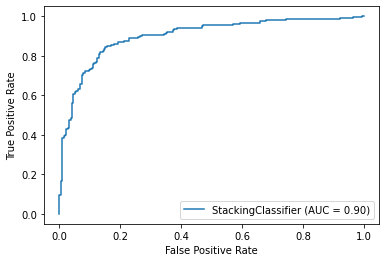

In [43]:
# Explicitly create a figure and axis
roc_disp = plot_roc_curve(model, X_val, y_val)
fig = plt.gcf()  # Get the current figure (gcf)


plt.savefig('/kaggle/working/bert_large_roc_curve.png')
plt.show()

In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.83      0.84      0.84       218
        True       0.86      0.84      0.85       238

    accuracy                           0.84       456
   macro avg       0.84      0.84      0.84       456
weighted avg       0.84      0.84      0.84       456



In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [47]:
cm = confusion_matrix(y_val, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)

<Figure size 432x288 with 0 Axes>

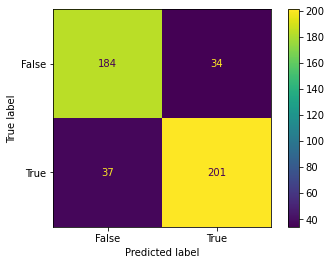

In [48]:
fig = plt.gcf()  # Get the current figure (gcf)
disp.plot()
plt.savefig('/kaggle/working/bert_small_confusion_mat.png')
plt.show()